In [ ]:
!pip install mne
!pip install tensorflow==2.14.0
!pip install tensorflow_privacy==0.9.0
!pip install pyriemann

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 106.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-privacy 0.9.0 requires numpy~=1.21, but you have numpy 2.3.0 which is incompatible.
dp-accounting 0.4.3 requires numpy~=1.21, but you have numpy 2.3.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.14.0 which is incompatible.
jax 0.5.2 requires ml_dtypes>=0.4.0, but you have ml-dtypes 0.2.0 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but 

In [ ]:
import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
# from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

In [ ]:
"""
 ARL_EEGModels - A collection of Convolutional Neural Network models for EEG
 Signal Processing and Classification, using Keras and Tensorflow

 Requirements:
    (1) tensorflow == 2.X (as of this writing, 2.0 - 2.3 have been verified
        as working)

 To run the EEG/MEG ERP classification sample script, you will also need

    (4) mne >= 0.17.1
    (5) PyRiemann >= 0.2.5
    (6) scikit-learn >= 0.20.1
    (7) matplotlib >= 2.2.3

 To use:

    (1) Place this file in the PYTHONPATH variable in your IDE (i.e.: Spyder)
    (2) Import the model as

        from EEGModels import EEGNet

        model = EEGNet(nb_classes = ..., Chans = ..., Samples = ...)

    (3) Then compile and fit the model

        model.compile(loss = ..., optimizer = ..., metrics = ...)
        fitted    = model.fit(...)
        predicted = model.predict(...)

 Portions of this project are works of the United States Government and are not
 subject to domestic copyright protection under 17 USC Sec. 105.  Those
 portions are released world-wide under the terms of the Creative Commons Zero
 1.0 (CC0) license.

 Other portions of this project are subject to domestic copyright protection
 under 17 USC Sec. 105.  Those portions are licensed under the Apache 2.0
 license.  The complete text of the license governing this material is in
 the file labeled LICENSE.TXT that is a part of this project's official
 distribution.
"""

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 64, Samples = 128,
             dropoutRate = 0.5, kernLength = 64, F1 = 8,
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:

        1. Depthwise Convolutions to learn spatial filters within a
        temporal convolution. The use of the depth_multiplier option maps
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn
        spatial filters within each filter in a filter-bank. This also limits
        the number of free parameters to fit when compared to a fully-connected
        convolution.

        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions.


    While the original paper used Dropout, we found that SpatialDropout2D
    sometimes produced slightly better results for classification of ERP
    signals. However, SpatialDropout2D significantly reduced performance
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.

    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the
    kernel lengths for double the sampling rate, etc). Note that we haven't
    tested the model performance with this rule so this may not work well.

    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D.

    Inputs:

      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D.
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)




def EEGNet_SSVEP(nb_classes = 12, Chans = 8, Samples = 256,
             dropoutRate = 0.5, kernLength = 256, F1 = 96,
             D = 1, F2 = 96, dropoutType = 'Dropout'):
    """ SSVEP Variant of EEGNet, as used in [1].

    Inputs:

      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn.
      D               : number of spatial filters to learn within each temporal
                        convolution.
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.


    [1]. Waytowich, N. et. al. (2018). Compact Convolutional Neural Networks
    for Classification of Asynchronous Steady-State Visual Evoked Potentials.
    Journal of Neural Engineering vol. 15(6).
    http://iopscience.iop.org/article/10.1088/1741-2552/aae5d8

    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense')(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)



def EEGNet_old(nb_classes, Chans = 64, Samples = 128, regRate = 0.0001,
           dropoutRate = 0.25, kernels = [(2, 32), (8, 4)], strides = (2, 4)):
    """ Keras Implementation of EEGNet_v1 (https://arxiv.org/abs/1611.08024v2)

    This model is the original EEGNet model proposed on arxiv
            https://arxiv.org/abs/1611.08024v2

    with a few modifications: we use striding instead of max-pooling as this
    helped slightly in classification performance while also providing a
    computational speed-up.

    Note that we no longer recommend the use of this architecture, as the new
    version of EEGNet performs much better overall and has nicer properties.

    Inputs:

        nb_classes     : total number of final categories
        Chans, Samples : number of EEG channels and samples, respectively
        regRate        : regularization rate for L1 and L2 regularizations
        dropoutRate    : dropout fraction
        kernels        : the 2nd and 3rd layer kernel dimensions (default is
                         the [2, 32] x [8, 4] configuration)
        strides        : the stride size (note that this replaces the max-pool
                         used in the original paper)

    """

    # start the model
    input_main   = Input((Chans, Samples))
    layer1       = Conv2D(16, (Chans, 1), input_shape=(Chans, Samples, 1),
                                 kernel_regularizer = l1_l2(l1=regRate, l2=regRate))(input_main)
    layer1       = BatchNormalization()(layer1)
    layer1       = Activation('elu')(layer1)
    layer1       = Dropout(dropoutRate)(layer1)

    permute_dims = 2, 1, 3
    permute1     = Permute(permute_dims)(layer1)

    layer2       = Conv2D(4, kernels[0], padding = 'same',
                            kernel_regularizer=l1_l2(l1=0.0, l2=regRate),
                            strides = strides)(permute1)
    layer2       = BatchNormalization()(layer2)
    layer2       = Activation('elu')(layer2)
    layer2       = Dropout(dropoutRate)(layer2)

    layer3       = Conv2D(4, kernels[1], padding = 'same',
                            kernel_regularizer=l1_l2(l1=0.0, l2=regRate),
                            strides = strides)(layer2)
    layer3       = BatchNormalization()(layer3)
    layer3       = Activation('elu')(layer3)
    layer3       = Dropout(dropoutRate)(layer3)

    flatten      = Flatten(name = 'flatten')(layer3)

    dense        = Dense(nb_classes, name = 'dense')(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input_main, outputs=softmax)



def DeepConvNet(nb_classes, Chans = 64, Samples = 256,
                dropoutRate = 0.5):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.

    This implementation assumes the input is a 2-second EEG signal sampled at
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference.

    Note that we use the max_norm constraint on all convolutional layers, as
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication
    with the original authors.

                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10

    Note that this implementation has not been verified by the original
    authors.

    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(25, (1, 5),
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)

    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)

    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)

    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)

    flatten      = Flatten()(block4)

    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)

    return Model(inputs=input_main, outputs=softmax)


# need these for ShallowConvNet
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))


def ShallowConvNet(nb_classes, Chans = 64, Samples = 128, dropoutRate = 0.5):
    """ Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), Human Brain Mapping.

    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.

    Note that we use the max_norm constraint on all convolutional layers, as
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication
    with the original authors.

                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25

    Note that this implementation has not been verified by the original
    authors. We do note that this implementation reproduces the results in the
    original paper with minor deviations.
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(40, (1, 13),
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False,
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)

    return Model(inputs=input_main, outputs=softmax)

In [ ]:
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
data_path = str(sample.data_path())

# Set parameters and read data
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

Using default location ~/mne_data for sample...
Creating /root/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 2.19TB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 01m45s (1576.2 MB)


In [ ]:
# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
labels = epochs.events[:, -1]

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

kernels, chans, samples = 1, 60, 151

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB



In [ ]:
import time
start = time.time()


In [ ]:
# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:144,]
Y_train      = y[0:144]
X_validate   = X[144:216,]
Y_validate   = y[144:216]
X_test       = X[216:,]
Y_test       = y[216:]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train-1)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)

# convert data to NHWC (trials, channels, samples, kernels) format. Data
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (144, 60, 151, 1)
144 train samples
72 test samples


In [ ]:
import os
os.makedirs('./tmp', exist_ok=True)

In [ ]:
model = DeepConvNet(nb_classes = 4, Chans = chans, Samples = samples, dropoutRate = 0.5)

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='./tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during
# optimization to balance it out. This data is approximately balanced so we
# don't need to do this, but is shown here for illustration/completeness.
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN +
# Riemannian geometry classification (below)
################################################################################
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300,
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

Epoch 1/300

Epoch 1: val_loss improved from inf to 1.38721, saving model to ./tmp/checkpoint.h5
9/9 - 3s - loss: 1.6033 - accuracy: 0.2083 - val_loss: 1.3872 - val_accuracy: 0.2639 - 3s/epoch - 389ms/step
Epoch 2/300


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.38721 to 1.38366, saving model to ./tmp/checkpoint.h5
9/9 - 1s - loss: 1.4729 - accuracy: 0.3264 - val_loss: 1.3837 - val_accuracy: 0.2361 - 764ms/epoch - 85ms/step
Epoch 3/300

Epoch 3: val_loss did not improve from 1.38366
9/9 - 1s - loss: 1.4140 - accuracy: 0.3125 - val_loss: 1.3937 - val_accuracy: 0.2500 - 683ms/epoch - 76ms/step
Epoch 4/300

Epoch 4: val_loss improved from 1.38366 to 1.37797, saving model to ./tmp/checkpoint.h5
9/9 - 1s - loss: 1.2870 - accuracy: 0.3750 - val_loss: 1.3780 - val_accuracy: 0.2917 - 722ms/epoch - 80ms/step
Epoch 5/300

Epoch 5: val_loss improved from 1.37797 to 1.35971, saving model to ./tmp/checkpoint.h5
9/9 - 1s - loss: 1.2392 - accuracy: 0.3750 - val_loss: 1.3597 - val_accuracy: 0.3750 - 700ms/epoch - 78ms/step
Epoch 6/300

Epoch 6: val_loss improved from 1.35971 to 1.31612, saving model to ./tmp/checkpoint.h5
9/9 - 1s - loss: 1.1791 - accuracy: 0.4236 - val_loss: 1.3161 - val_accuracy: 0.4167 - 724ms/epoch - 80m

In [ ]:
# load optimal weights
model.load_weights('./tmp/checkpoint.h5')

###############################################################################
# can alternatively used the weights provided in the repo. If so it should get
# you 93% accuracy. Change the WEIGHTS_PATH variable to wherever it is on your
# system.
###############################################################################

# WEIGHTS_PATH = /path/to/EEGNet-8-2-weights.h5
# model.load_weights(WEIGHTS_PATH)

###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))


############################# PyRiemann Portion ##############################

# code is taken from PyRiemann's ERP sample script, which is decoding in
# the tangent space with a logistic regression

n_components = 2  # pick some components

# set up sklearn pipeline
clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

preds_rg     = np.zeros(len(Y_test))

# reshape back to (trials, channels, samples)
X_train      = X_train.reshape(X_train.shape[0], chans, samples)
X_test       = X_test.reshape(X_test.shape[0], chans, samples)

# train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# labels need to be back in single-column format
clf.fit(X_train, Y_train.argmax(axis = -1))
preds_rg     = clf.predict(X_test)

# Printing the results
acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
print("Classification accuracy: %f " % (acc2))

3/3 [==============================] - 0s 26ms/step
Classification accuracy: 0.819444 
Classification accuracy: 0.944444 


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
# plot the confusion matrices for both classifiers
names        = ['audio left', 'audio right', 'vis left', 'vis right']
# plt.figure(0)
confusion_matrix_1 = confusion_matrix(preds, Y_test.argmax(axis = -1))

# plt.figure(1)
confusion_matrix_2 = confusion_matrix(preds_rg, Y_test.argmax(axis = -1))

In [ ]:
confusion_matrix_1

array([[12,  6,  0,  0],
       [ 5, 12,  0,  0],
       [ 0,  0, 18,  1],
       [ 0,  1,  0, 17]])

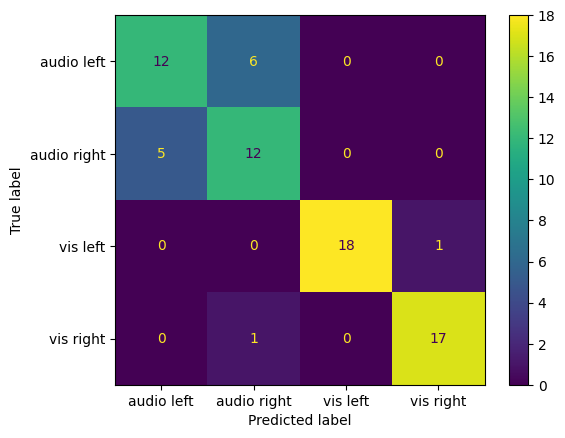

In [ ]:
disp1 = ConfusionMatrixDisplay(confusion_matrix_1, display_labels = names)
disp1.plot()

# ConfusionMatrixDisplay(confusion_matrix_2, display_labels = names)

In [ ]:
print(classification_report(preds, Y_test.argmax(axis = -1)))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        18
           1       0.63      0.71      0.67        17
           2       1.00      0.95      0.97        19
           3       0.94      0.94      0.94        18

    accuracy                           0.82        72
   macro avg       0.82      0.82      0.82        72
weighted avg       0.83      0.82      0.82        72



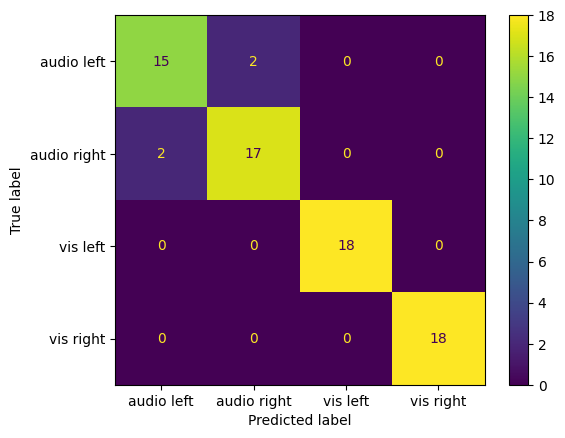

In [ ]:
disp2 = ConfusionMatrixDisplay(confusion_matrix_2, display_labels = names)
disp2.plot()

In [ ]:
end = time.time()
print(f"Took {end - start:.2f} seconds")

Took 239.52 seconds
